# `pyGIMLi(emg3d)`

Create an env with the correct packages using
```bash
mamba env create
mamba activate pg-emg3d
python -m ipykernel install --user --name pg-emg3d
```

**Or run the following cell to install the inversion branch of emg3d** (change it to a code cell)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

import emg3d
import pygimli as pg

# Requires currently branch `inversion` (see above cell):
from emg3d.inversion.pygimli import Kernel, Inversion

## Load simulation

Data loaded from «/home/dtr/Codes/dev-pygimli-emg3d/toy-tiny.h5»
[emg3d v1.8.3.dev12+g868edad (format 1.0) on 2024-06-24T16:43:23.251234].


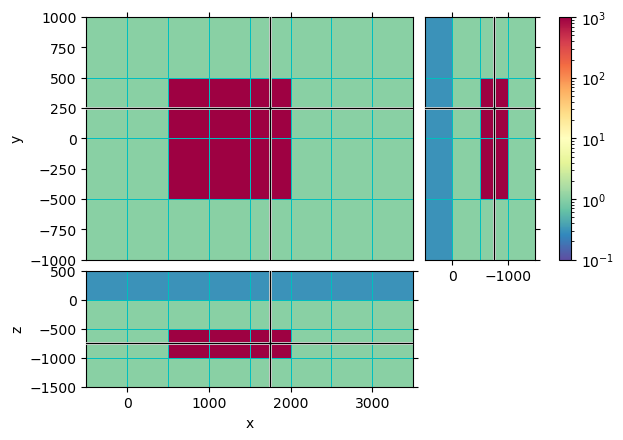


  TensorMesh: 128 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x      8       -500.00      3,500.00    500.00    500.00    1.00
   y      4     -1,000.00      1,000.00    500.00    500.00    1.00
   z      4     -1,500.00        500.00    500.00    500.00    1.00


Model: conductivity; isotropic; 8 x 4 x 4 (128)
:: Simulation ::

- Survey: 1 sources; 130 receivers; 1 frequencies
- Model: conductivity; isotropic; 8 x 4 x 4 (128)
- Gridding: Frequency- and source-dependent grids; 64 x 48 x 40 (122,880)


In [2]:
#name = 'toy-small.h5'
name = 'toy-tiny.h5'
try:
    toy = emg3d.load(name)
except:
    %run toyexample.py
    toy = emg3d.load(name)

sim = toy['sim']
model_true = toy['model_true']
model_start = sim.model.copy()
grid = model_true.grid

grid.plot_3d_slicer(
    1/model_true.property_x, zslice=-750,
    pcolor_opts={'cmap': 'Spectral_r', 'norm': LogNorm(vmin=.1, vmax=1000), 'lw': 0.5, 'color': 'c'}
)

print(grid)
print(model_true)
print(sim)

## Define regions, instantiate Kernel and Inversion

In [3]:
# Create region markers (as many different regions as you like)
markers = np.zeros(model_start.shape, dtype=int)
#markers[:, :, grid.cell_centers_z > -500] = 1     # top two layers and bottom two layers
markers[model_true.property_x < 0.1] = 1            # Only target is free
#markers = np.zeros(model_start.shape, dtype=int)
#markers[1:-1, :, :][:, 1:-1, :][:, :, 1:-2] = 1

# Instantiate the emg3d-kernel for pyGIMLi
fop = Kernel(simulation=sim, markers=markers, pgthreads=1)

# Instantiate the inversion and set some inversion parameters
INV = Inversion(fop=fop)
INV.inv.setCGLSTolerance(10)  # is _absolute_, not _relative_
INV.inv.setMaxCGLSIter(30)
#INV.dataTrans = pg.trans.TransSymLog(sim.survey.noise_floor)

# Set the regions.
# Any number of regions is possible; alse `fix=True`, `single=True`, and `background=True`.
# Two different ways of the same: INV.setRegularization; INV.fop.setRegionProperties
INV.fop.setRegionProperties(1, single=True, limits=(0.0001, 2), startModel=1.0)  # Target
INV.fop.setRegionProperties(0, background=True)                                               # Background

# Constrain types (cType)
# 0 only damping (minimum length; only useful with good starting model and isReference=True in INV)
# 1 1st deriv - smoothing
# 2 2nd deriv
# 10, 20 - mixed form

# Depth weighting
# https://www.pygimli.org/_examples_auto/4_gravimetry_magnetics/plot_08_inv-magnetics-3d.html#depth-weighting

## Run inversion

In [4]:
#INV.stopAtChi1 = False
errmodel = INV.run(
    #maxIter=2, # just to test
    lam=10,  # btw 1-100
    #verbose=True,
    #debug=True,
    #startModel=model_true.property_x.ravel('F'),
    #isReference=True,
)

24/06/24 - 17:01:47 - pyGIMLi - INFO - :: pyGIMLi(emg3d) START ::
24/06/24 - 17:01:47 - pyGIMLi - INFO - Created startmodel from region infos: 1 [1.0]
24/06/24 - 17:01:48 - pyGIMLi - INFO - 0: χ² =   17.20; λ = 10.0;  1 kernel calls; ϕ = 4471.22 + 0.00·λ = 4471.22
24/06/24 - 17:04:08 - pyGIMLi - INFO - 1: χ² =    0.26; λ = 10.0; 65 kernel calls; ϕ = 68.17 + 55.82·λ = 626.36; Δϕ = 85.99%
24/06/24 - 17:04:08 - pyGIMLi - INFO - :: pyGIMLi(emg3d) END   :: runtime = 0:02:21


# Plots

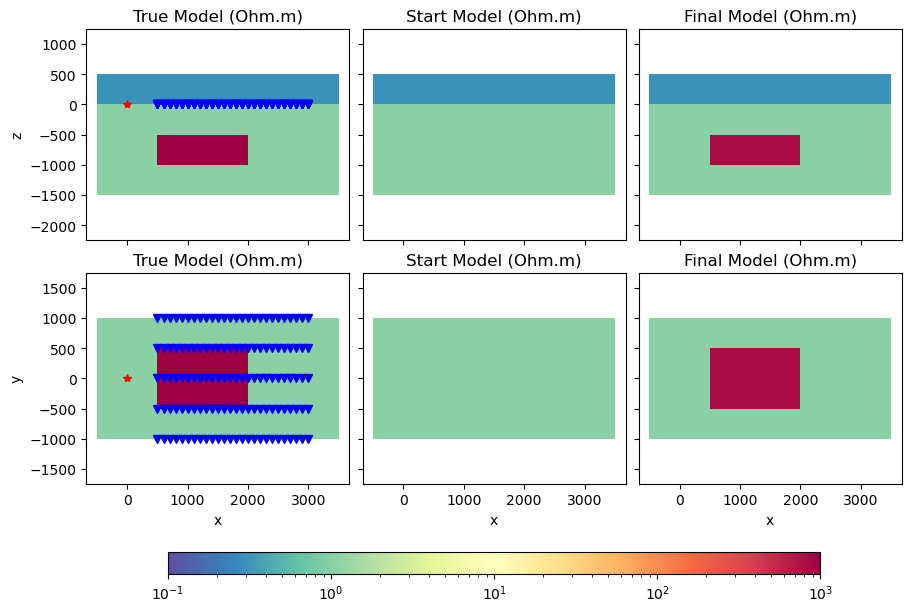

In [5]:
popts1 = {'cmap':'Spectral_r','norm':LogNorm(vmin=0.1, vmax=1000)}
popts2 = {'edgecolors': 'grey', 'linewidth': 0.5, 'cmap':'Spectral_r','norm':LogNorm(vmin=0.1, vmax=1000)}
opts = {'v_type': 'CC', 'normal': 'Y'}

rec_coords = sim.survey.receiver_coordinates()
src_coords = sim.survey.source_coordinates()

fig, axs = plt.subplots(2, 3, figsize=(9, 6), constrained_layout=True)#, sharey='row', sharex='col')
(ax1, ax2, ax3), (ax4, ax5, ax6) = axs

# True model
out1, = grid.plot_slice(1/model_true.property_x.ravel('F'), ax=ax1, pcolor_opts=popts1, **opts)
ax1.set_title(f"True Model (Ohm.m)")
ax1.plot(rec_coords[0], rec_coords[2], 'bv')
ax1.plot(src_coords[0], src_coords[2], 'r*')

# Start model
out2, = grid.plot_slice(1/model_start.property_x.ravel('F'), ax=ax2, pcolor_opts=popts1, **opts)
ax2.set_title(f"Start Model (Ohm.m)")

# Final inversion model
out3, = grid.plot_slice(1/sim.model.property_x.ravel('F'), ax=ax3, pcolor_opts=popts1, **opts)
ax3.set_title(f"Final Model (Ohm.m)")

opts['normal'] = 'Z'
opts['ind'] = 1

# True model
out4, = grid.plot_slice(1/model_true.property_x.ravel('F'), ax=ax4, pcolor_opts=popts1, **opts)
ax4.set_title(f"True Model (Ohm.m)")
ax4.plot(rec_coords[0], rec_coords[1], 'bv')
ax4.plot(src_coords[0], src_coords[1], 'r*')

# Start model
out5, = grid.plot_slice(1/model_start.property_x.ravel('F'), ax=ax5, pcolor_opts=popts1, **opts)
ax5.set_title(f"Start Model (Ohm.m)")

# Final inversion model
out6, = grid.plot_slice(1/sim.model.property_x.ravel('F'), ax=ax6, pcolor_opts=popts1, **opts)
ax6.set_title(f"Final Model (Ohm.m)")

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('')
    ax.set_xticklabels([])
    
for ax in [ax2, ax3, ax5, ax6]:
    ax.set_ylabel('')
    ax.set_yticklabels([])

for ax in axs.ravel():
    ax.axis('equal')

plt.colorbar(out1, ax=axs, orientation='horizontal', fraction=.1, shrink=.8, aspect=30);

In [6]:
def pos(data):
    """Return positive data; set negative data to NaN."""
    return np.where(data > 0, data, np.nan)

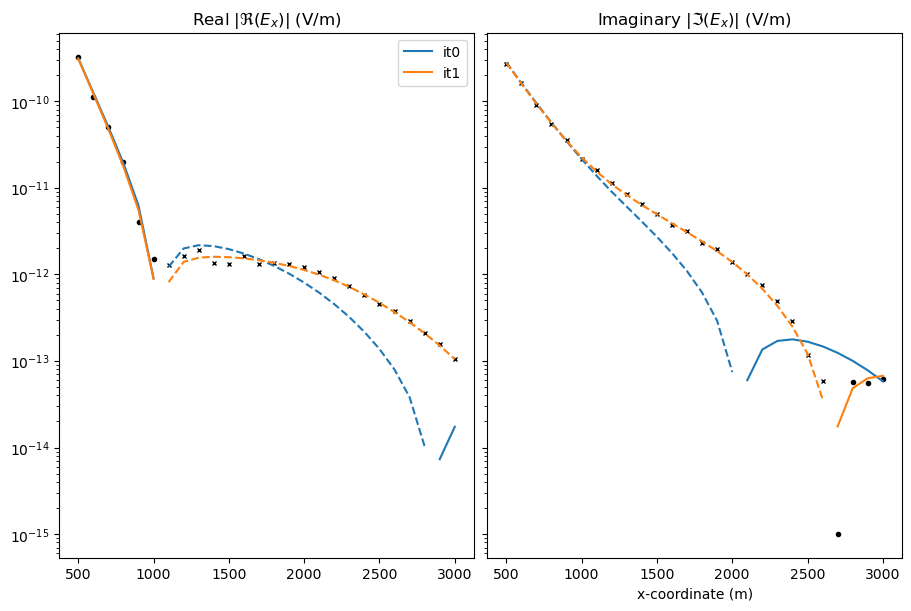

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(9, 6), constrained_layout=True, sharex=True, sharey=True)
xa = 26*2
xb = 26*3

# Observed data
axs[0].plot(rec_coords[0][xa:xb], pos(sim.data.observed.data.real[0, xa:xb, 0]), f"k.")
axs[0].plot(rec_coords[0][xa:xb], pos(-sim.data.observed.data.real[0, xa:xb, 0]), f"kx", ms=3)
axs[1].plot(rec_coords[0][xa:xb], pos(sim.data.observed.data.imag[0, xa:xb, 0]), f"k.")
axs[1].plot(rec_coords[0][xa:xb], pos(-sim.data.observed.data.imag[0, xa:xb, 0]), f"kx", ms=3)

for i in range(INV.iter+1):
    n = f"it{i}"
    axs[0].plot(rec_coords[0][xa:xb], pos(sim.data[n].data.real[0, xa:xb, 0]), f"C{i%10}-", label=n)
    axs[0].plot(rec_coords[0][xa:xb], pos(-sim.data[n].data.real[0, xa:xb, 0]), f"C{i%10}--")
    axs[1].plot(rec_coords[0][xa:xb], pos(sim.data[n].data.imag[0, xa:xb, 0]), f"C{i%10}-")
    axs[1].plot(rec_coords[0][xa:xb], pos(-sim.data[n].data.imag[0, xa:xb, 0]), f"C{i%10}--")

axs[0].set_yscale('log')
axs[0].set_title('Real $|\Re(E_x)|$ (V/m)')
axs[1].set_title('Imaginary $|\Im(E_x)|$ (V/m)')
axs[0].legend()
axs[1].set_xlabel('x-coordinate (m)');

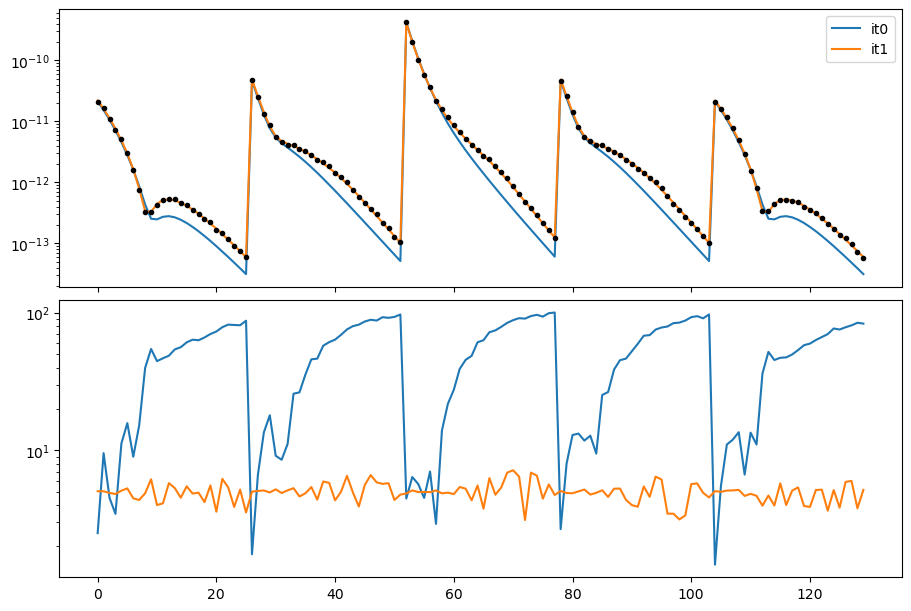

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(9, 6), constrained_layout=True, sharex=True)
for i in range(INV.iter+1):
    n = f"it{i}"
    axs[0].plot(np.abs(sim.data[n].squeeze()), f"C{i%10}-", label=n)
    rms = 100*np.abs((sim.data[n].squeeze() - sim.data.observed.squeeze()))/np.abs(sim.data.observed.squeeze())
    axs[1].plot(rms, f"C{i%10}-")
axs[0].plot(np.abs(sim.data.observed.squeeze()), f"k.")
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].legend();

In [9]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Mon Jun 24 17:04:09 2024 CEST

                OS : Linux (Ubuntu 22.04)
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37)
  [GCC 12.3.0]

             numpy : 1.26.4
             scipy : 1.13.1
             numba : 0.59.1
             emg3d : 1.8.3.dev12+g868edad
           empymod : 2.2.2
            xarray : 2024.1.0
        discretize : 0.10.0
              h5py : 3.9.0
        matplotlib : 3.8.2
              tqdm : 4.66.1
           IPython : 8.25.0
           pygimli : 1.5.1+44.g8375bffb
            pgcore : 1.5.0
--------------------------------------------------------------------------------